In [1]:
import torch
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = np.zeros((3, 6), dtype=np.float32)
s = [4, 1, 3]
mask = np.tile(np.arange(6), reps=(3, 1)) < np.tile(s, (6, 1)).T
data[mask] = 0
data[~mask] = 1
data

array([[0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.]], dtype=float32)

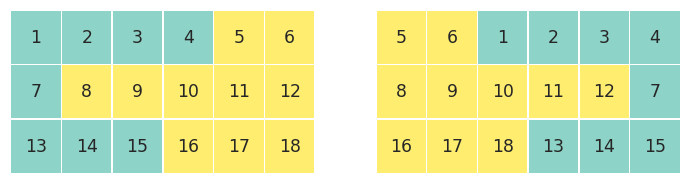

In [3]:
annot = np.tile(np.arange(6), reps=(3, 1))
annot = np.arange(1, 19).reshape(3, 6)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 3))

rev_annot = []
rev_data = []
for i in range(annot.shape[0]):
    sp = s[i]
    rev_annot.append(
        np.concatenate((annot[i, sp:], annot[i, :sp]))
    )
    rev_data.append(
        np.concatenate((data[i, sp:], data[i, :sp]))
    )
rev_annot = np.stack(rev_annot)
rev_data = np.stack(rev_data)

sns.heatmap(data, ax=ax[0], cbar=False, linewidths=.5, cmap='Set3',
            annot=annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'xx-large'})

sns.heatmap(rev_data, ax=ax[1], cbar=False, linewidths=.5, cmap='Set3',
            annot=rev_annot, xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': 'xx-large'})

fig.savefig("random_shift_rows.png", dpi=100)

In [33]:
N = 1000
M = 2000
splits = torch.from_numpy(np.random.randint(M, size=N))
X = torch.FloatTensor(N, M).random_(200, 500).cuda()

In [34]:
def swap_each(X, splits):
    N = X.size(0)
    M = X.size(1)
    mask = torch.arange(M, out=torch.LongTensor()).repeat((N, 1)) < splits.repeat((M, 1)).t()
    X2 = torch.zeros_like(X)
    i = np.repeat(range(N), X.size(1) - splits)
    j = list(itertools.chain(*(range(s.item(), X.size(1)) for s in splits)))
    flipped_mask = mask[:, list(range(X.size(1)-1, -1, -1))]
    X2[~flipped_mask] = X[i, j]
    i = np.repeat(range(N), splits)
    j = list(itertools.chain(*(range(s) for s in splits)))
    X2[flipped_mask] = X[i, j]
    return X2

swap_each(X, splits)

tensor([[ 263.,  215.,  458.,  ...,  243.,  316.,  315.],
        [ 292.,  329.,  321.,  ...,  202.,  379.,  451.],
        [ 356.,  250.,  295.,  ...,  266.,  280.,  440.],
        ...,
        [ 334.,  400.,  310.,  ...,  489.,  325.,  368.],
        [ 486.,  426.,  323.,  ...,  427.,  417.,  364.],
        [ 434.,  267.,  314.,  ...,  279.,  244.,  463.]], device='cuda:0')

tensor([[ 486.,  373.,  219.,  ...,  227.,  322.,  385.],
        [ 466.,  297.,  216.,  ...,  235.,  326.,  206.],
        [ 343.,  252.,  430.,  ...,  233.,  407.,  209.],
        ...,
        [ 485.,  430.,  251.,  ...,  309.,  220.,  206.],
        [ 471.,  355.,  328.,  ...,  236.,  319.,  468.],
        [ 339.,  284.,  415.,  ...,  356.,  418.,  309.]])

In [35]:
def swap_each2(X, splits):
    N = X.size(0)
    M = X.size(1)
    all_idx = torch.arange(M, out=torch.LongTensor()).repeat((N, 1))
    all_j = torch.arange(N, out=torch.LongTensor()).repeat((M, 1)).t()
    mask = all_idx < splits.repeat((M, 1)).t()
    X2 = torch.zeros_like(X)
    i = all_j[~mask]
    j = all_idx[~mask]
    flipped_mask = mask[:, list(range(M-1, -1, -1))]
    X2[~flipped_mask] = X[i, j]
    i = all_j[mask]
    j = all_idx[mask]
    X2[flipped_mask] = X[i, j]
    return X2

swap_each2(X, splits)

tensor([[ 263.,  215.,  458.,  ...,  243.,  316.,  315.],
        [ 292.,  329.,  321.,  ...,  202.,  379.,  451.],
        [ 356.,  250.,  295.,  ...,  266.,  280.,  440.],
        ...,
        [ 334.,  400.,  310.,  ...,  489.,  325.,  368.],
        [ 486.,  426.,  323.,  ...,  427.,  417.,  364.],
        [ 434.,  267.,  314.,  ...,  279.,  244.,  463.]], device='cuda:0')

In [36]:
def swap_each3(X, splits):
    swapped = []
    for i, row in enumerate(X):
        swapped.append(
            torch.cat((row[splits[i]:], row[:splits[i]]))
        )
    return torch.stack(swapped)

swap_each3(X, splits)

tensor([[ 263.,  215.,  458.,  ...,  243.,  316.,  315.],
        [ 292.,  329.,  321.,  ...,  202.,  379.,  451.],
        [ 356.,  250.,  295.,  ...,  266.,  280.,  440.],
        ...,
        [ 334.,  400.,  310.,  ...,  489.,  325.,  368.],
        [ 486.,  426.,  323.,  ...,  427.,  417.,  364.],
        [ 434.,  267.,  314.,  ...,  279.,  244.,  463.]], device='cuda:0')

In [37]:
def swap_each4(X, splits):
    for i, row in enumerate(X):
        if i == 0:
            swapped = torch.cat((row[splits[i]:], row[:splits[i]])).view(1, -1)
        else:
            swapped = torch.cat((
                swapped,
                torch.cat((row[splits[i]:], row[:splits[i]])).view(1, -1)
            ))
    return swapped

In [38]:
%%timeit
swap_each(X, splits)

144 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
swap_each2(X, splits)

258 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
swap_each3(X, splits)

21.6 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
swap_each4(X, splits)

55.8 ms ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
torch.nonzero(swap_each(X, splits) != swap_each2(X, splits))

tensor([], dtype=torch.int64)

In [24]:
torch.nonzero(swap_each3(X, splits) != swap_each2(X, splits))

tensor([], dtype=torch.int64)

In [25]:
torch.nonzero(swap_each3(X, splits) != swap_each4(X, splits))

tensor([], dtype=torch.int64)